In [79]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jr
import jax.numpy.linalg as jnl
import matplotlib.pyplot as plt
from jax import grad, vmap
from jax.config import config
from multipledispatch import dispatch
from flax import nn

key = jsr.PRNGKey(123)

Aim: create a GP regression class in Jax

# Simulate data

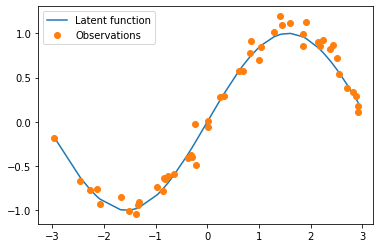

In [80]:
n = 50
x = jr.uniform(key, shape=(n, ), minval=-3., maxval=3.).sort()
signal = jnp.sin(x)
noise = jr.normal(key, signal.shape)*0.1
y = signal+noise

plt.plot(x, signal, label='Latent function')
plt.plot(x, y, 'o', label='Observations')
plt.legend(loc='best')

# Define Zero-Mean

In [81]:
def zero(x):
    return jnp.zeros_like(x)

# Define kernel

In [82]:
def gram(kernel, xs):
    return vmap(lambda x: vmap(lambda y: kernel(x, y))(xs))(xs)


# TODO: Only works for 1-dimensional inputs right now
def rbf(lengthscale, variance):
    def kernel(x, y):
        tau = jnp.square(x-y)
        return jnp.square(variance)*jnp.exp(-tau/(2*jnp.square(lengthscale)))
    return kernel

## Test kernel

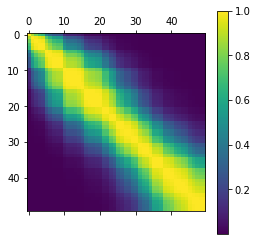

In [83]:
kfunc = rbf(1.0, 1.0)
K = gram(kfunc, x)
plt.matshow(K)
plt.colorbar()

### Check Gram matrix is PSD

In [84]:
jnp.all(jnl.eigvals(K)>0)

DeviceArray(False, dtype=bool)

In [85]:
def jitter_matrix(n: int, jitter_amount:float = 1e-6):
    return jnp.eye(n)*jitter_amount

jitter_mat = jitter_matrix(n, 1e-6)
Kstable = K + jitter_mat

In [86]:
jnp.all(jnl.eigvals(Kstable)>0)

DeviceArray(True, dtype=bool)

## Build GP object

In [161]:
from typing import Callable

class GP:
    def __init__(self, kernel, meanf=zero, name=None):
        self.kernel = kernel
        self.mean_func = meanf
        self.name = name
        

class Prior(GP):
    def __init__(self, kernel, meanf=zero, name: str = "Prior"):
        super().__init__(kernel, meanf, name) # Add in a default zero-mean function
        
    def setup(self):
        pass
    
    def __mul__(self, other):
        return Posterior(self, other)
    

class Posterior(GP):
    # TODO: Maybe have a meanf and likelihood "type"
    def __init__(self, prior: Prior, likelihood, name: str = "Posterior"):
        super().__init__(prior.kernel, prior.mean_func, name)
        self.prior = prior
        self.likelihood = likelihood

    

In [162]:
kernel = rbf(lengthscale=1.0, variance=1.0)
gp = Prior(kernel)

In [163]:
# @dispatch(Prior, x)
def sample(key, gp, x):
    mu = gp.mean_func(x)
    K = gram(gp.kernel, x)
    # TODO: Possible idea return a distribution instead of a set of samples
    samples = jr.multivariate_normal(key, jnp.squeeze(mu), k, size=n_samples)

In [165]:
x = jnp.linspace(-3., 3., 200)
mu = gp.mean_func(x)
jitter_mat = jitter_matrix(x.shape[0], 1e-6)
K = gram(gp.kernel, x, x) + jitter_mat

NotImplementedError: Could not find signature for feature_map: <function>

In [102]:
from flax import struct 

@struct.dataclass
class GaussianProcess:
    index_points: jnp.ndarray
    mean_function: Callable = struct.field(pytree_node=False)
    kernel_function: Callable = struct.field(pytree_node=False)
    jitter: float

In [104]:
p = GaussianProcess(x, zero, kernel, 1e-6)

# Flax Approach

In [166]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jr
import jax.numpy.linalg as jnl
import matplotlib.pyplot as plt
from jax import grad, vmap
from jax.config import config
from multipledispatch import dispatch
from flax import linen as nn, struct
from multipledispatch import dispatch

key = jsr.PRNGKey(123)

In [185]:
@struct.dataclass
class Kernel:
    pass

@struct.dataclass
class SquaredExponential(Kernel):
    lengthscale: float = struct.field(pytree_node=True)
    variance: float = struct.field(pytree_node=True)

@struct.dataclass
class MeanFunction:
    pass
        
@struct.dataclass
class ZeroMean:
    pass
        
@struct.dataclass
class Prior:
    mean_function: Callable = struct.field(pytree_node=False)
    kernel_function: Callable = struct.field(pytree_node=False)
    jitter: float

In [186]:
def squared_exponential(lengthscale, variance):
    return SquaredExponential(lengthscale, variance)

squared_exponential(1.0, 1.0)

SquaredExponential(lengthscale=1.0, variance=1.0)

## Mean functions

In [187]:
m = ZeroMean()

@dispatch(ZeroMean)
def mean_function(M: ZeroMean):
    return jnp.zeros_like

## Kernel methods

In [188]:
def kernel_map(func, x, y):
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(y))(x)

@dispatch(SquaredExponential)
def feature_map(kernel: SquaredExponential):
    def fmap(x, y):
        tau = jnp.square(x-y)
        return jnp.square(kernel.variance) * jnp.exp(-tau/(2*jnp.square(kernel.lengthscale)))
    return fmap

def gram(kernel, x, y):
    fmap = feature_map(kernel)
    K = kernel_map(fmap, x, y)
    return K


In [189]:
mfunc = mean_function(k)

In [190]:
mfunc(x)

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0.], dtype=float32)

In [191]:
kernel = SquaredExponential(1.0, 1.0)
x = jnp.linspace(-1., 1., 50)
K = gram(kernel, x, x)

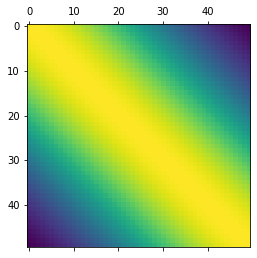

In [192]:
plt.matshow(K)

In [225]:
@struct.dataclass
class Likelihood:
    pass


@struct.dataclass
class Gaussian:
    noise: float
        

class Prior(nn.Module):
    kernel: Kernel
    mean_function: MeanFunction
    
    @nn.compact
    def __call__(self, inputs):
        pass # TODO: Add in the predictive mean of the GP. Maybe the MLL might be required
    
    def __mul__(self, other: Likelihood):
        return Posterior(self, other)
    

class Posterior(nn.Module):
    prior: Prior
    likelihood: Likelihood
    
    @nn.compact
    def __call__(self, inputs):
        pass

In [226]:
f_prior = Prior(kernel, mfunc)
likelihood = Gaussian(1.0)

In [227]:
f_post = Posterior(f_prior, likelihood)

In [228]:
f_post = f_prior*likelihood

ValueError: Can't call methods on orphaned modules